In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
from hippylib import nb
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False

import matplotlib.pyplot as plt
from helper_algorithms import interior_pt

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

In [3]:
def csr_fenics2scipy(A_fenics):
    ai, aj, av = dl.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    A_scipy.eliminate_zeros()
    return A_scipy

class Boundary(dl.SubDomain):
    def inside(me, x, on_boundary):
        return on_boundary

    
"""
An object which will internally handle the finite-element
discretization of the infinite-dimensional inverse problem
and set up the linear KKT system.
"""    

class KKT:
    def __init__(me, Vh, Vhs, beta, gamma, gamma1, ml, ud, f):
        me.Vh    = Vh
        me.Vhs   = Vhs
        # size of operator
        me.n     = me.Vh.dim() + me.Vh.sub(0).dim()
        # lower-bound on parameter
        me.ml    = ml
        # data that we are fitting the model to
        me.ud    = ud
        # rhs
        me.f = f
        
        # index relevant to obtain
        # subblocks of 2x2 discretization
        me.idx   = me.Vh.sub(0).dim()
        me.beta  = beta
        me.gamma = gamma
        me.gamma1 = gamma1
        utest, mtest = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        Muform       = utest * utrial * dl.dx(me.Vh.mesh())
        Rform        = dl.Constant(gamma) * mtest * mtrial * dl.dx(me.Vh.mesh())
        Mform        = mtest * mtrial * dl.dx(me.Vh.mesh())
        Kform        = (dl.inner(dl.grad(utest), dl.grad(utrial)) + \
                        dl.Constant(beta) * utest * utrial)*dl.dx(me.Vh.mesh())
        Cform        = dl.Constant(-1.0) * utest * mtrial * dl.dx(me.Vh.mesh())
        CTform       = dl.Constant(-1.0) * utrial * mtest * dl.dx(me.Vh.mesh())
        me.C_fenics  = dl.assemble(Cform)
        me.CT_fenics = dl.assemble(CTform)
        me.CT        = csr_fenics2scipy(me.CT_fenics)[me.idx:, :me.idx]
        me.C         = csr_fenics2scipy(me.C_fenics)[:me.idx, me.idx:]
        me.K_fenics  = dl.assemble(Kform)
        me.K         = csr_fenics2scipy(me.K_fenics)[:me.idx,:me.idx]
        
        me.R_fenics  = dl.assemble(Rform)
        me.R         = csr_fenics2scipy(me.R_fenics)[me.idx:, me.idx:]
        me.M_fenics  = dl.assemble(Mform)
        me.M         = csr_fenics2scipy(me.M_fenics)[me.idx:,me.idx:]
        me.Mu_fenics = dl.assemble(Muform)
        me.Mu        = csr_fenics2scipy(me.Mu_fenics)[:me.idx,:me.idx]
        me.A         = sps.bmat([[me.Mu, None, me.K], \
                                 [None, me.R, me.CT], \
                                 [me.K, me.C, None]], format="csr")
        me.Mx        = sps.bmat([[me.Mu, None], \
                                 [None, me.M]], format="csr")
        # indicies for the block splitting defined by the Uzawa
        me.idx0       = me.Vh.dim()
        """
         define a 2x2 partitioning of the 3x3
         state-parameter-adjoint KKT linear system
         the 2x2 block is null for all problems as
         the adjoint variable always enters linearly into
         the Lagrangian functional
        """
        me.A11        = sps.bmat([[me.Mu, None],\
                                  [None, me.R]], format="csr")
        me.A12        = sps.bmat([[me.K],\
                                  [me.CT]], format="csr")
        me.A21        = sps.bmat([[me.K, me.C]], format="csr")
        
        me.help = dl.Function(me.Vh)
    def rhs(me, ud):
        utest, mtest = dl.TestFunctions(me.Vh)
        f = dl.assemble(utest*ud*dl.dx(me.Vh.mesh())).get_local()
        output = np.zeros(me.n)
        output[:me.idx0] = f[:]
        return output
    """
    In what follows x will be a function on the state-parameter product
    finite-element space
    """
    
    """
    J -- return the value of the regularized data-misfit functional at x
    """
    def J(me, x):
        return dl.assemble((dl.Constant(0.5) * (x.sub(0)-me.ud)**2. + \
                           dl.Constant(me.gamma/2.)*x.sub(1)*x.sub(1) + \
                           dl.Constant(me.gamma1/2.)*dl.inner(\
                           dl.grad(x.sub(1)), dl.grad(x.sub(1))))*dl.dx(me.Vh.mesh()))
    """
    DxJ -- return the (dual) variational derivative of J with respect to x
    """
    def DxJ(me, x):
        utest, mtest = dl.TestFunctions(me.Vh)
        return dl.assemble(((x.sub(0) - me.ud)*utest + \
                            dl.Constant(me.gamma)*\
                            x.sub(1)*mtest + \
                            dl.Constant(me.gamma1) * \
                            dl.inner(dl.grad(x.sub(1)), dl.grad(mtest)))*dl.dx(me.Vh.mesh())).get_local()
    """ 
    return the second variational derivative of J with respect to x, that is 
    a linear mapping from primal to dual 
    """
    def DxxJ(me, x):
        utest, mtest = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return csr_fenics2scipy(dl.assemble((utrial*utest + \
                                dl.Constant(me.gamma)*\
                                mtrial*mtest + \
                                dl.Constant(me.gamma1)*\
                                dl.inner(dl.grad(mtest), dl.grad(mtrial)))*dl.dx(me.Vh.mesh())))
    """
    return the value of the log-barrier objective at x and parameter \mu
    """ 
    def phi(me, x, mu):
        logPenalty = dl.interpolate(dl.Expression(('0.', 'std::log(m-ml)'), \
                                    element=me.Vh.ufl_element(), m=x.sub(1), ml=me.ml), \
                         me.Vh) 
        return me.J(x) - mu * dl.assemble(logPenalty.sub(1)*dl.dx(me.Vh.mesh()))
    """
    return the variational derivative of the log-barrier objective with respect
    to x
    """
    def Dxphi(me, x, mu):
        logPenalty = dl.interpolate(dl.Expression(('0.', '1. / (m-ml)'), \
                                    element=me.Vh.ufl_element(), m=x.sub(1), ml=me.ml), \
                         me.Vh)
        utest, mtest = dl.TestFunctions(me.Vh)
        return me.DxJ(x) - mu *\
               dl.assemble((utest*logPenalty.sub(0) + mtest*logPenalty.sub(1))*dl.dx(me.Vh.mesh())).get_local()
    """
    evaluate the PDE-constraint at x, returning a dual-vector 
    """    
    def c(me, x):
        utest, mtest = dl.TestFunctions(me.Vh)
        return dl.assemble((x.sub(1)*dl.inner(dl.grad(x.sub(0)), dl.grad(utest)) + \
                            dl.Constant(me.beta)*x.sub(0)*utest - me.f*utest)*dl.dx(me.Vh.mesh()))\
                            .get_local()[:me.idx]
    """
    evaluate the variational derivative of the PDE-constraint with respect
    to x, 
    return a linear mapping from the primal to the dual
    """
    def Dxc(me, x):
        utest, mtest   = dl.TestFunctions(me.Vh)
        p, _ = dl.TrialFunctions(me.Vh)
        return csr_fenics2scipy(\
                   dl.assemble((x.sub(1)*dl.inner(dl.grad(utest), dl.grad(p)) + \
                                mtest*dl.inner(dl.grad(x.sub(0)), dl.grad(p))+ me.beta*utest*p)*dl.dx(me.Vh.mesh())))[:,:me.idx]
    def Dxxcp(me, X):
        x, p, z = X[:]
        utest, mtest   = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return csr_fenics2scipy(dl.assemble((mtest * dl.inner(dl.grad(utrial), dl.grad(p)) + \
                                             mtrial * dl.inner(dl.grad(utest), dl.grad(p)))*\
                                            dl.dx(me.Vh.mesh())))
    """
    evaluate the Lagrangian at x, p, z
    """
    def L(me, X):
        x, p, z = X[:]
        return me.J(x) + p.vector().get_local().dot(me.c(x)) - \
               dl.assemble(z*(x.sub(1, deepcopy=True) - me.ml)*dl.dx(me.Vh.mesh()))
    """
    evaluate the variational derivative of the Lagrangian with respect
    to x at x,p,z
    return a dual-vector
    """
    def DxL(me, X):
        x, p, z = X[:]
        utest, mtest = dl.TestFunctions(me.Vh)
        return me.DxJ(x) + \
               me.Dxc(x).dot(p.vector().get_local()) - dl.assemble(z*mtest*dl.dx(me.Vh.mesh())).get_local()
    def DxxL(me, X):
        x, p, z = X[:]
        return me.DxxJ(x) + me.Dxxcp(X)
    """
    Evaluate the optimality error of the barrier-problem
    """
    def E(me, X, mu, smax):
        x, p, z = X[:]
        znp  = z.vector().get_local()[:]
        mnp  = x.vector().get_local()[me.idx:]
        mlnp = me.ml.vector().get_local()[:]
        zL2 = np.sqrt(np.dot(znp, me.M.dot(znp)))
        
        pnp = p.vector().get_local()[:]
        pL2 = np.sqrt(np.dot(pnp, me.Mu.dot(pnp)))
        
        sc = max(zL2, smax)/smax
        sd = max(0.5*(zL2 + pL2), smax) / smax
        #E1 = np.linalg.norm(me.DxL(X), np.inf)
        DxL = me.DxL(X)
        MinvDxL = spla.spsolve(me.Mx, DxL)
        E1 = np.sqrt(np.dot(MinvDxL, DxL))
        #E2 = np.linalg.norm(me.c(x),   np.inf)
        cx = me.c(x)
        Minvcx = spla.spsolve(me.Mu, cx)
        E2 = np.sqrt(np.dot(Minvcx, cx))
        E3 = np.linalg.norm(znp * (mnp - mlnp) - mu, np.inf)
        return max(E1 / sd, E2, E3 / sc), E1 / sd, E2, E3 / sc
    def theta(me, x):
        cx = me.c(x)
        Minvcx = spla.spsolve(me.Mu, cx)
        return np.sqrt(np.dot(Minvcx, cx))
    def restore_feasibility(me, x):
        utest  = dl.TestFunction(me.Vhs[1])
        utrial = dl.TrialFunction(me.Vhs[1])
        rhs    = dl.assemble(me.f*utest*dl.dx(me.Vhs[1].mesh()))
        sysmat = csr_fenics2scipy(dl.assemble((x.sub(1)*dl.inner(dl.grad(utest), dl.grad(utrial)) + \
                            me.beta*utest*utrial)*dl.dx(me.Vhs[1].mesh())))
        sol = spla.spsolve(sysmat, rhs)
        return sol
 

# Define the mesh.

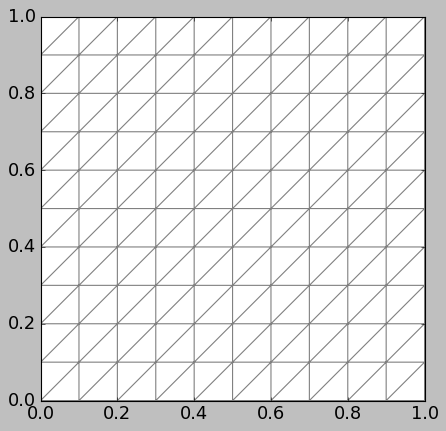

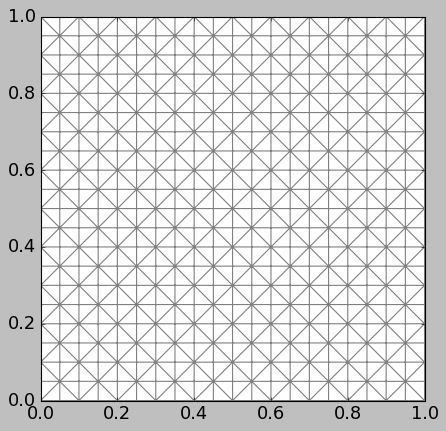

In [4]:
nx = 10

mesh_coarse = dl.UnitSquareMesh(nx, nx)
meshes = [mesh_coarse]
levels = 2
ref_levels = levels-1
for i in range(ref_levels):
    meshes.append(dl.refine(meshes[i-1]))
#mesh  = dl.refine(mesh_coarse)
dl.plot(meshes[0])
plt.show()
dl.plot(meshes[-1])
plt.show()
#meshes = [mesh_coarse, mesh]

Form the discretized state/parameter product finite-element space. With this one can determine all sub-blocks of the KKT linear system which are discretization of (mixed) sparse finite element matrices.

# Define finite element spaces over the mesh. 

In [5]:
# finite element for parameter/bound-constrained multiplier on each mesh
P1s  = [dl.FiniteElement("DG", meshes[i].ufl_cell(), 0) for i in range(levels)]

# finite element for state/adjoint on each mesh
P2s  = [dl.FiniteElement("CG", meshes[i].ufl_cell(), 1) for i in range(levels)]

# state-parameter product space, the full-space optimization variable
Ths  = [dl.MixedElement([P2s[i], P1s[i]]) for i in range(levels)]

# state-parameter product finite-element function space
Vhs  = [dl.FunctionSpace(meshes[i], Ths[i]) for i in range(levels)]

# bound-constraint multiplier finite-element function space
Vh1s = [dl.FunctionSpace(meshes[i], P1s[i]) for i in range(levels)]

# adjoint variable finite-element function space
Vh2s = [dl.FunctionSpace(meshes[i], P2s[i]) for i in range(levels)]

# state-parameter, adjoint, bound-constraint multiplier
Vhss = [[Vhs[i], Vh2s[i], Vh1s[i]] for i in range(levels)] 

In [6]:
beta  = 1.e-2
gamma = 1.e-4
gamma1 = 0.
mls   = [dl.interpolate(dl.Expression('0.75', element=Vh1s[i].ufl_element()), Vh1s[i]) \
                                      for i in range(levels)]
uds  = [dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                      pi=np.pi, element=Vh2s[i].ufl_element()), Vh2s[i]) for i in range(levels)]

fs   = [dl.interpolate(dl.Expression('(2.*pi*pi*(0.5+x[0]) + beta)*std::cos(x[0]*pi)*std::cos(x[1]*pi)'+\
                                      '+pi*std::sin(pi*x[0])*std::cos(pi*x[1])',\
                                       pi=np.pi, beta=beta, \
                                      element=Vh2s[i].ufl_element()), Vh2s[i]) for i in range(levels)] 

mtrues = [dl.interpolate(dl.Expression('0.5+x[0]',\
                                     element=Vh1s[i].ufl_element()), Vh1s[i]) \
                                     for i in range(levels)]

KKT_problems = [KKT(Vhs[i], Vhss[i], beta, gamma, gamma1, mls[i], uds[i], fs[i]) for i in range(levels)]

### Gradient Check

Calling FFC just-in-time (JIT) compiler, this may take some time.


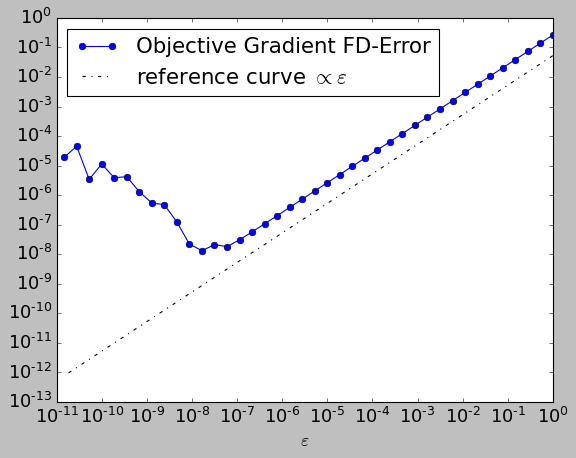

[]

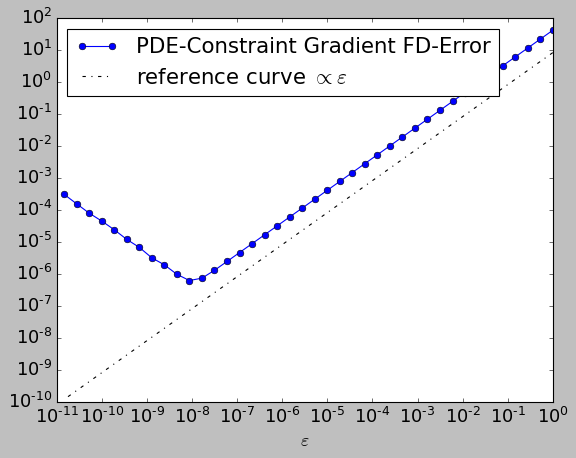

In [7]:
KKT_problem = KKT_problems[-1]
x0 = dl.Function(Vhs[-1])
xdir = dl.Function(Vhs[-1]).vector()
x0.vector().set_local(np.ones(Vhs[-1].dim()))
xdir.set_local(np.random.randn(Vhs[-1].dim()))

J0     = KKT_problem.J(x0)
c0     = KKT_problem.c(x0)
Dxc0   = KKT_problem.Dxc(x0)


g0     = KKT_problem.DxJ(x0)
g0xdir = g0.dot(xdir.get_local())
Dxc0xdir = Dxc0.transpose().dot(xdir.get_local())



x = dl.Function(Vhs[-1])
epss = np.logspace(-36, 0, num=40, base=2.0)[::-1]
errs = np.zeros(len(epss))
Jderiv_errors = np.zeros(len(epss))
cderiv_errors = np.zeros(len(epss))
for i, eps in enumerate(epss):
    x.assign(x0)
    x.vector().axpy(eps, xdir)
    Jeps = KKT_problem.J(x)
    ceps = KKT_problem.c(x)
    Jderiv_errors[i]  = abs((Jeps - J0) / eps - g0xdir)
    cderiv_errors[i]  = np.linalg.norm((ceps - c0)/ eps - Dxc0xdir, 2)

plt.plot(epss, Jderiv_errors, "-ob", label="Objective Gradient FD-Error")
plt.plot(epss, 0.2 *(Jderiv_errors[0]/epss[0])*epss, "-.k", label=r"reference curve $\propto\varepsilon$")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\varepsilon$')
plt.legend(loc = "upper left")
plt.show()


plt.plot(epss, cderiv_errors, "-ob", label="PDE-Constraint Gradient FD-Error")
plt.plot(epss, 0.2* (cderiv_errors[0]/epss[0])*epss, "-.k", label=r"reference curve $\propto\varepsilon$")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\varepsilon$')
plt.legend(loc = "upper left")
plt.plot()



In [8]:
optimizers = [interior_pt(KKT_problems[i], Vhss[i]) for i in range(levels)]
optimizer  = optimizers[-1]


tol=1.e-8
maxiter = 10
mu0 = 1.e0
X, mu, Es, Mus = optimizer.solve(tol, maxiter,mu0)
Es = np.array(Es)

it = 0
Calling FFC just-in-time (JIT) compiler, this may take some time.
linearized KKT sys residual = 2.479e-14
alpha = 1.000e+00
alphaz = 1.000e+00
A.5.5
A.5.6
alpha_soc = 1.000e+00
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
A.5.5
A-5.10
FILTER LINE SEARCH FAILURE -- should continue to feasibility restoration A-9
feasibility restoration
it = 1
linearized KKT sys residual = 2.090e-09
alpha = 1.405e-05
alphaz = 1.000e+00
A.5.4
it = 2
linearized KKT sys residual = 9.721e-14
alpha = 1.000e+00
alphaz = 1.000e+00
A.5.4
it = 3
linearized KKT sys residual = 3.746e-10
alpha = 1.365e-04
alphaz = 1.000e+00
A.5.4
A.5.5
A.5.6
alpha_soc = 1.365e-04
not acceptable to the filter
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5.10
A.5.4
A.5.5
A-5

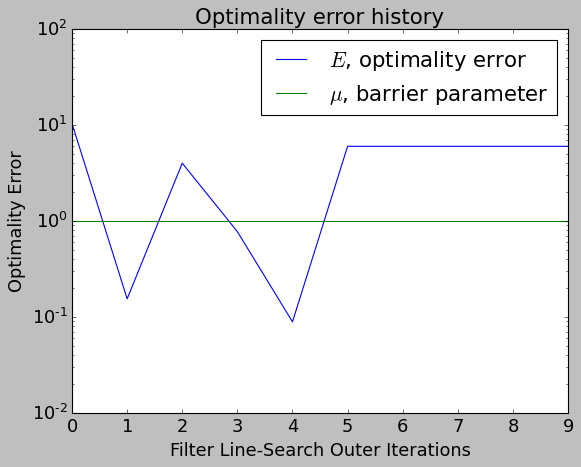

In [9]:
plt.plot(Es[:,0], label=r'$E$, optimality error')
plt.plot(Mus, label=r'$\mu$, barrier parameter')
plt.yscale('log')
plt.title('Optimality error history')
plt.ylabel('Optimality Error')
plt.xlabel('Filter Line-Search Outer Iterations')
plt.legend()
plt.show()

mu_final = 1.000e+00
0.32056883563362765
-1.041e+00 <= u(x,y) <= 1.041e+00
1.043e+00 <= m(x,y) <= 2.652e+00


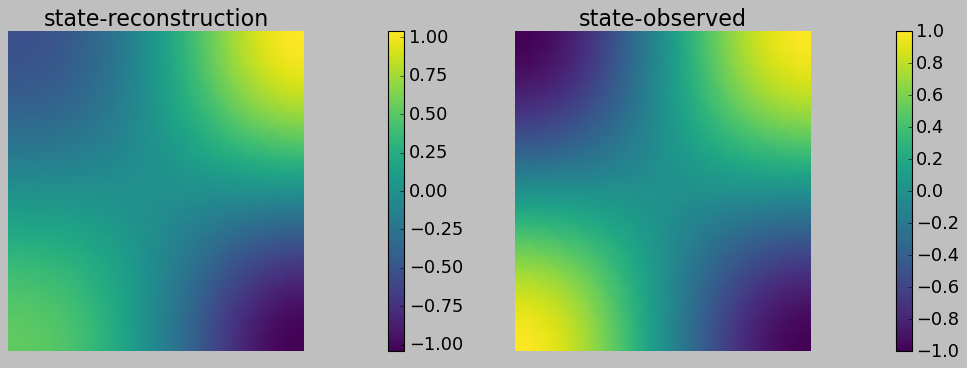

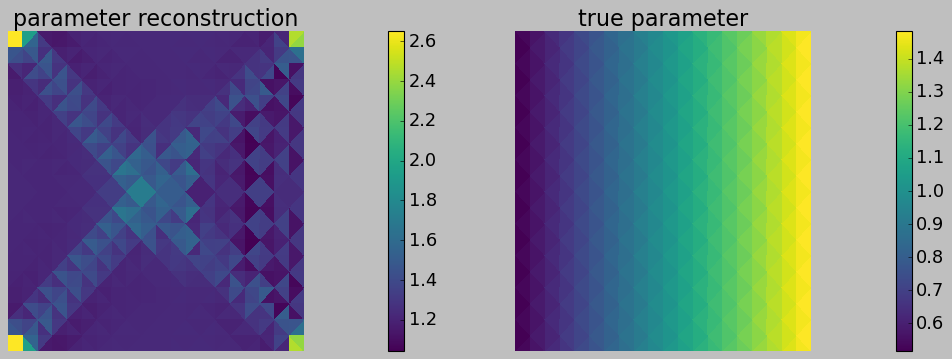

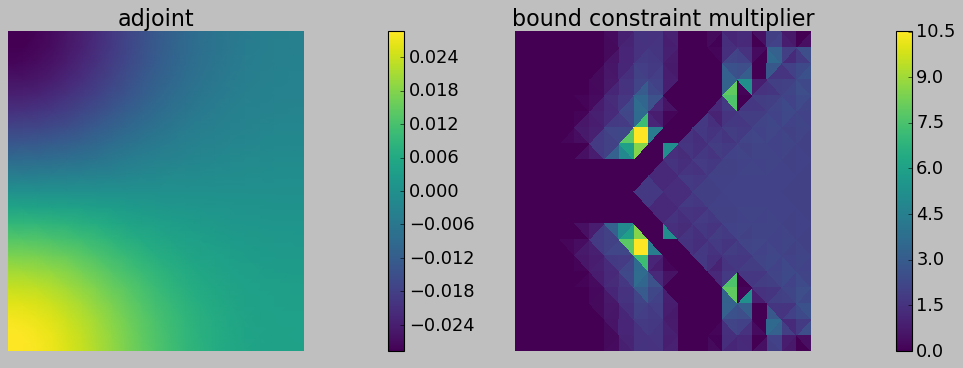

In [10]:
print("mu_final = {0:1.3e}".format(mu))


print(np.sqrt(dl.assemble((uds[-1] - X[0].sub(0))**2.*dl.dx(meshes[-1]))) /\
      np.sqrt(dl.assemble(uds[-1]**2*dl.dx(meshes[-1]))))
print("{0:1.3e} <= u(x,y) <= {1:1.3e}".format(\
      X[0].sub(0, deepcopy=True).vector().min(), X[0].sub(0, deepcopy=True).vector().max()))
print("{0:1.3e} <= m(x,y) <= {1:1.3e}".format(\
      X[0].sub(1, deepcopy=True).vector().min(), X[0].sub(1, deepcopy=True).vector().max()))

nb.multi1_plot([X[0].sub(0,deepcopy=True), uds[-1]], ["state-reconstruction", "state-observed"], same_colorbar=False)
plt.show()
nb.multi1_plot([X[0].sub(1,deepcopy=True), mtrues[-1]], ["parameter reconstruction", "true parameter"], \
               same_colorbar=False)
plt.show()
nb.multi1_plot([X[1], X[2]], ["adjoint", "bound constraint multiplier"], same_colorbar=False)
plt.show()


#dl.File("figures/m.pvd") << X[0].sub(1)
#dl.File("figures/mtrue.pvd") << mtrues[-1]
#dl.File("figures/ureconstruction.pvd") << X[0].sub(0)
#dl.File("figures/ud.pvd") << uds[-1]
#dl.File("figures/p.pvd") << X[1]
#dl.File("figures/z.pvd") << X[2]
